# AI System Implementation - Exploring difference approches

- dataset: food101

## Importing Library

In [1]:
import math
import time
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

## Downloading dataset

In [2]:
dataset_name = "food101"
train_dataset = tfds.load(dataset_name, split="train", as_supervised=True)
test_dataset = tfds.load(dataset_name, split="validation", as_supervised=True)  # Using predefined test set
info = tfds.builder(dataset_name).info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.Y1J8X1_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.Y1J8X1_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Understanding the dataset

In [3]:
info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    split

## Limited Classes

In [4]:
CLASSES = 10 # Number of classes

In [5]:
# Get only the first `CLASSES` labels
selected_classes = tf.constant(list(range(CLASSES)), dtype=tf.int64)
labels = info.features['label'].names[:CLASSES]

# Efficient function to filter dataset based on selected classes
def filter_classes(image, label):
    return tf.reduce_any(tf.equal(label, selected_classes))

# Apply filtering
filtered_train_dataset = train_dataset.filter(filter_classes)
test_ds = test_dataset.filter(filter_classes)

In [6]:
# Get dataset sizes efficiently
def dataset_size(dataset):
    return dataset.reduce(tf.constant(0), lambda x, _: x + 1).numpy()

train_size = dataset_size(filtered_train_dataset)
test_size = dataset_size(test_ds)

print(f"Filtered Train dataset size: {train_size}")
print(f"Filtered Test dataset size: {test_size}")

Filtered Train dataset size: 7500
Filtered Test dataset size: 2500


## Visaulizing Sample Images

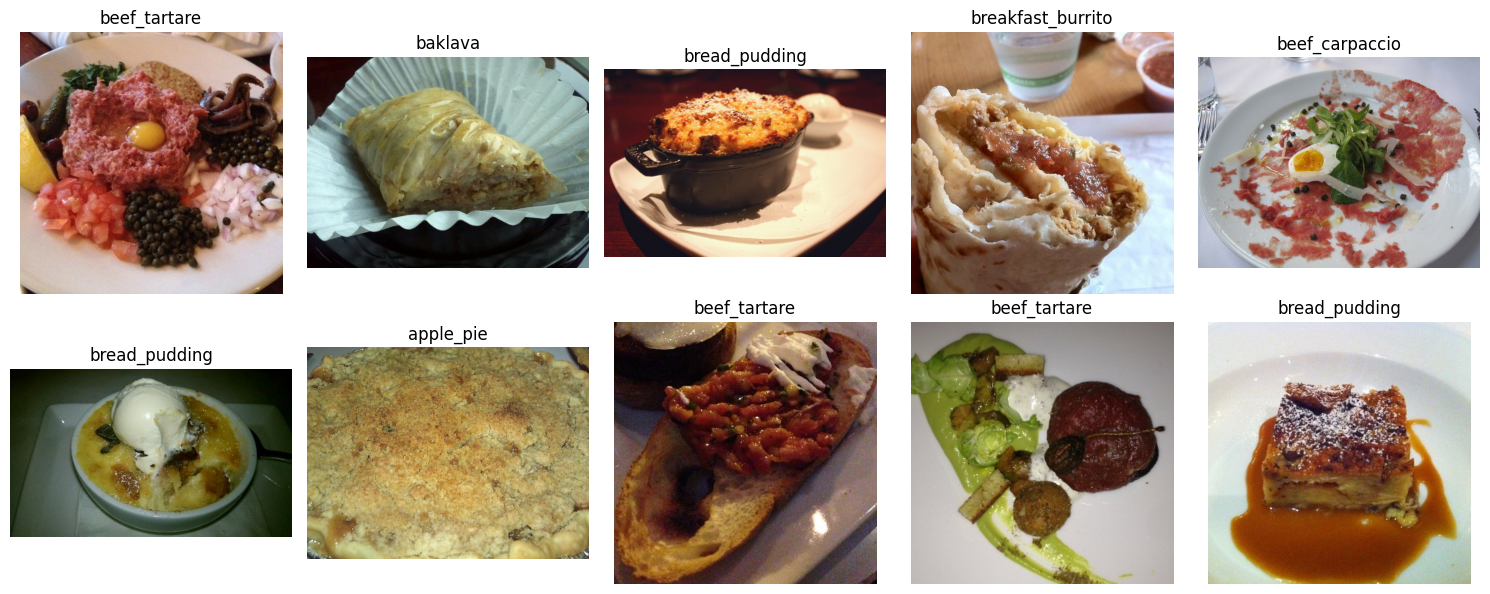

In [7]:
# Dynamically determine the grid size for plotting
cols = min(CLASSES, 5)  # Max 5 columns for better layout
rows = math.ceil(CLASSES / cols)

# Create visualization grid
plt.figure(figsize=(cols * 3, rows * 3))  # Adjust figure size dynamically
for i, (image, label) in enumerate(filtered_train_dataset.take(CLASSES)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(image.numpy().astype('uint8'))
    plt.title(labels[label.numpy()])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Shuffle before Splitting

In [8]:
# Shuffle before splitting (Ensures random train/validation split)
filtered_train_dataset = filtered_train_dataset.shuffle(10000, reshuffle_each_iteration=False)

## Dataset Splitting

In [9]:
train_split = 0.8
full_train_size = train_size
train_size = int(train_split * full_train_size)

train_ds = filtered_train_dataset.take(train_size)
val_ds = filtered_train_dataset.skip(train_size)

train_size = dataset_size(train_ds)
val_size = dataset_size(val_ds)

print(f"Filtered Train set size: {train_size}")
print(f"Filtered Validation set size: {val_size}")

Filtered Train set size: 6000
Filtered Validation set size: 1500


## Feature engineering & Data Augmentation

### Standardizing & Normalizing Pixel Values

In [10]:
# Normalize pixel values to [0,1]
def normalize(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Converts from [0, 255] → [0, 1]
    return image, label

### Common Augmentations for Image Classification

In [11]:
# Define augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # Flip images horizontally
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Contrast
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)  # Saturation
    return image, label

### Optimized Data Pipeline

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # Optimized processing

## Utility Function

### Image

In [13]:
def get_image_shape(image_size, channels=3):
    return (image_size, image_size, channels)

# Function to resize images
def resize(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

def pipeline_preprocessing():
  # Processing Dataset
  train_set = train_ds.repeat().map(resize).map(normalize).map(augment).shuffle(10000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
  val_set = val_ds.repeat().map(resize).map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)
  test_set = test_ds.map(resize).map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)

  return train_set, val_set, test_set


### Model

In [14]:
def generate_model (pretraining_model, dense=256, dropout=0.6, learning_rate=1e-4):
  base_model = pretraining_model(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
  base_model.trainable = False

  # Add custom classification layers
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(dense, activation="relu")(x)
  x = Dropout(dropout)(x)

  output_layer = Dense(CLASSES, activation="softmax")(x)
  model = Model(inputs=base_model.input, outputs=output_layer)

  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()

  return base_model, model

def fine_tune_model (base_model, model, learning_rate=1e-5):
  base_model.trainable = True

  # Recompile model with lower learning rate
  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

  return model

In [15]:
def train_model (model, train_set, val_set):
  STEPS_PER_EPOCH = train_size // BATCH_SIZE  # Calculate number of steps per epoch
  VALIDATION_STEPS = val_size // BATCH_SIZE   # Same for validation

  early_stopping = EarlyStopping(
    monitor="val_loss",  # Stop when validation loss stops improving
    patience=5,  # Wait 5 epochs before stopping
    restore_best_weights=True  # Keep the best model
  )

  lr_scheduler = ReduceLROnPlateau(
      monitor="val_loss",
      factor=0.5,  # Reduce by half
      patience=3,  # Wait 3 epochs
      min_lr=1e-6
  )

  # Train model
  start_time = time.time()
  # Train model with early stopping
  history = model.fit(
      train_set,
      validation_data=val_set,
      epochs=EPOCHES,
      steps_per_epoch=STEPS_PER_EPOCH,
      validation_steps=VALIDATION_STEPS,
      callbacks=[early_stopping, lr_scheduler]
  )
  end_time = time.time()
  training_time = end_time - start_time

  return history, training_time, model

### Graph

In [16]:
def plot_accuracy_n_loss(history):
    # Plot accuracy and loss graphs
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

In [17]:
def gen_report(model, test_set, history, fine_tune_history, initial_training_time, fine_tuning_time):
  # Generate predictions on validation dataset
  # Store predictions in TensorFlow tensors (avoids NumPy conversion issues)
  STEPS = math.ceil(test_size / BATCH_SIZE)
  y_true = tf.concat([labels for _, labels in test_set], axis=0)
  y_pred = tf.argmax(model.predict(test_set, steps=STEPS), axis=1)

  # Classification Report
  class_report = classification_report(y_true, y_pred, target_names=labels)
  print(class_report)

  # Calculate average accuracy and loss for training and validation (before fine-tuning)
  avg_train_acc = np.mean(history.history['accuracy'])
  avg_val_acc = np.mean(history.history['val_accuracy'])
  avg_train_loss = np.mean(history.history['loss'])
  avg_val_loss = np.mean(history.history['val_loss'])

  # Calculate average accuracy and loss for training and validation (after fine-tuning)
  avg_train_acc_fine = np.mean(fine_tune_history.history['accuracy'])
  avg_val_acc_fine = np.mean(fine_tune_history.history['val_accuracy'])
  avg_train_loss_fine = np.mean(fine_tune_history.history['loss'])
  avg_val_loss_fine = np.mean(fine_tune_history.history['val_loss'])

  # Display results
  print("=== Initial Training ===")
  print(f"Average Training Accuracy: {avg_train_acc:.4f}")
  print(f"Average Validation Accuracy: {avg_val_acc:.4f}")
  print(f"Average Training Loss: {avg_train_loss:.4f}")
  print(f"Average Validation Loss: {avg_val_loss:.4f}\n")

  print("=== After Fine-Tuning ===")
  print(f"Average Training Accuracy (Fine-Tuned): {avg_train_acc_fine:.4f}")
  print(f"Average Validation Accuracy (Fine-Tuned): {avg_val_acc_fine:.4f}")
  print(f"Average Training Loss (Fine-Tuned): {avg_train_loss_fine:.4f}")
  print(f"Average Validation Loss (Fine-Tuned): {avg_val_loss_fine:.4f}")

  # Confusion Matrix
  conf_matrix = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

  # Display runtime performance
  print(f"Initial Training Time: {initial_training_time:.2f} seconds")
  print(f"Fine-Tuning Time: {fine_tuning_time:.2f} seconds")

### Variable

In [18]:
BATCH_SIZE = 32
EPOCHES = 10

## Model

### InceptionV3

#### Build Model

In [19]:
IMG_SIZE = 299
IMG_SHAPE = get_image_shape(IMG_SIZE)

In [20]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

base_model, model = generate_model(InceptionV3)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,329,898 (85.18 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

#### Train Model (Before Fine-Tuning)

In [21]:
# Processing Dataset
train_set, val_set, test_set = pipeline_preprocessing()

In [22]:
history, initial_training_time, model = train_model(model, train_set, val_set)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 116s 265ms/step - accuracy: 0.1043 - loss: 19.2045 - val_accuracy: 0.1135 - val_loss: 2.3137 - learning_rate: 1.0000e-04
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 51s 275ms/step - accuracy: 0.1025 - loss: 2.3587 - val_accuracy: 0.1230 - val_loss: 2.2855 - learning_rate: 1.0000e-04
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 51s 275ms/step - accuracy: 0.1089 - loss: 2.3262 - val_accuracy: 0.1107 - val_loss: 2.2934 - learning_rate: 1.0000e-04
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 269ms/step - accuracy: 0.1073 - loss: 2.2999 - val_accuracy: 0.1250 - val_loss: 2.2870 - learning_rate: 1.0000e-04
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 264ms/step - accuracy: 0.1204 - loss: 2.2993 - val_accuracy: 0.1155 - val_loss: 2.2845 - learning_rate: 1.0000e-04
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 264ms/step - accuracy: 0.1218 - loss: 2.2890 - val_accuracy: 0.1284 - val_loss: 2.2668 - learning_rate: 1.0000e-04
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 57s 

##### Accuracy and Loss Graph

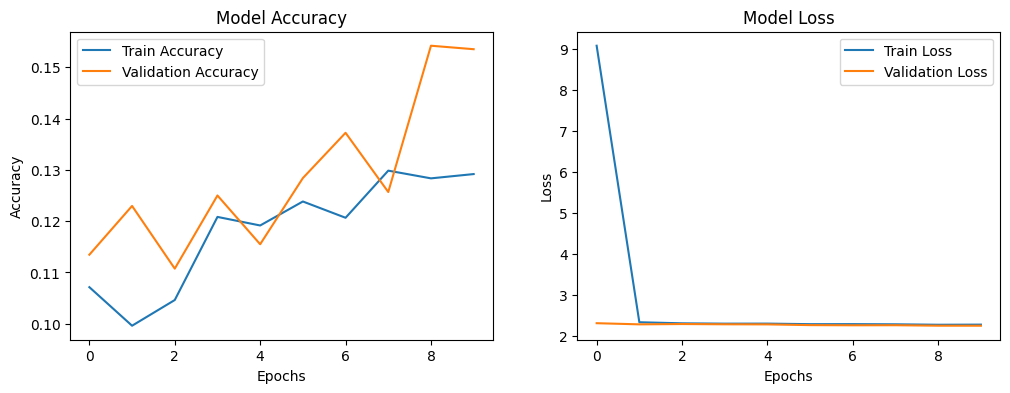

In [23]:
plot_accuracy_n_loss(history)

#### Fine-Tuning

In [24]:
model = fine_tune_model(base_model, model)

In [25]:
# Fine-tune model
fine_tune_history, fine_tuning_time, model = train_model(model, train_set, val_set)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 158s 251ms/step - accuracy: 0.1480 - loss: 2.2801 - val_accuracy: 0.3505 - val_loss: 2.0355 - learning_rate: 1.0000e-05
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 269ms/step - accuracy: 0.3533 - loss: 1.9792 - val_accuracy: 0.5448 - val_loss: 1.5260 - learning_rate: 1.0000e-05
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 270ms/step - accuracy: 0.5351 - loss: 1.5190 - val_accuracy: 0.7208 - val_loss: 1.0781 - learning_rate: 1.0000e-05
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 270ms/step - accuracy: 0.6585 - loss: 1.1435 - val_accuracy: 0.7833 - val_loss: 0.7996 - learning_rate: 1.0000e-05
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 270ms/step - accuracy: 0.7601 - loss: 0.8564 - val_accuracy: 0.8173 - val_loss: 0.6306 - learning_rate: 1.0000e-05
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 271ms/step - accuracy: 0.7967 - loss: 0.7137 - val_accuracy: 0.8308 - val_loss: 0.5516 - learning_rate: 1.0000e-05
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 60s 3

##### Accuracy and Loss Graph

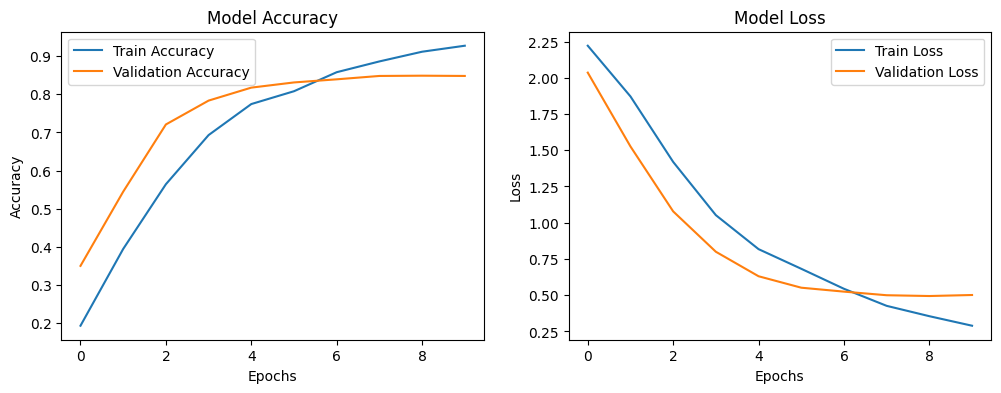

In [26]:
plot_accuracy_n_loss(fine_tune_history)

#### Evaluate Model

In [28]:
# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_set)
print(f"Test Accuracy: {test_acc*100:.4f}%")
print(f"Test Loss: {test_loss:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.8876 - loss: 0.3558
Test Accuracy: 88.2000%
Test Loss: 0.3819


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step
                   precision    recall  f1-score   support

        apple_pie       0.74      0.76      0.75       250
   baby_back_ribs       0.92      0.95      0.93       250
          baklava       0.88      0.92      0.90       250
   beef_carpaccio       0.90      0.90      0.90       250
     beef_tartare       0.89      0.88      0.88       250
       beet_salad       0.84      0.84      0.84       250
         beignets       0.94      0.94      0.94       250
         bibimbap       0.96      0.96      0.96       250
    bread_pudding       0.85      0.72      0.78       250
breakfast_burrito       0.91      0.94      0.92       250

         accuracy                           0.88      2500
        macro avg       0.88      0.88      0.88      2500
     weighted avg       0.88      0.88      0.88      2500

=== Initial Training ===
Average Training Accuracy: 0.1183
Average Validation Accuracy: 0.1287
Average Training Loss: 2.9762
Aver

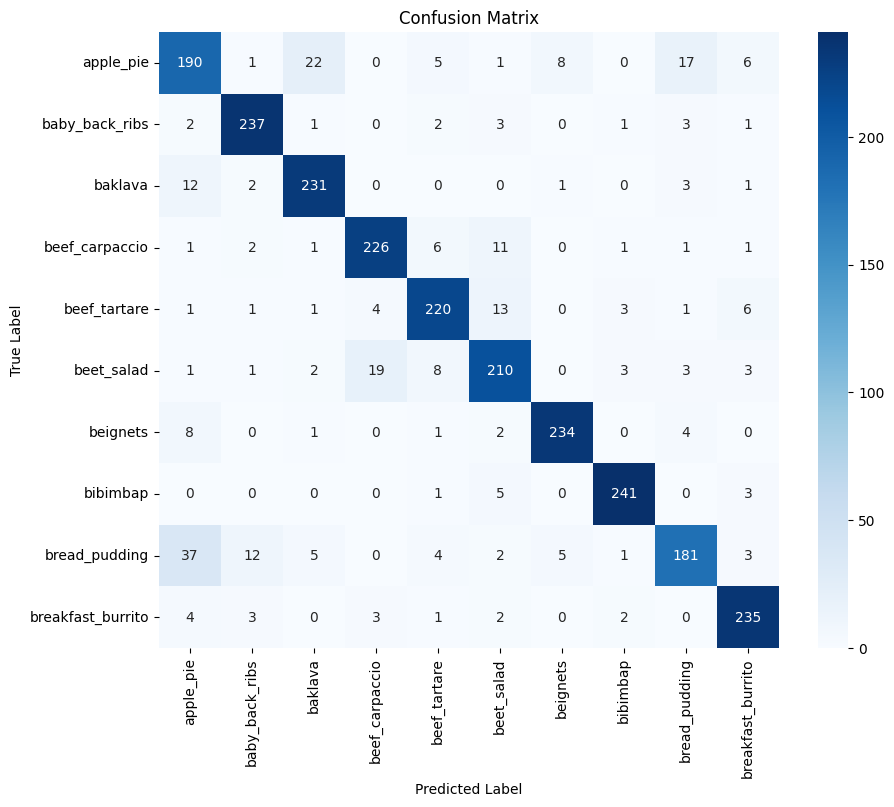

Initial Training Time: 562.74 seconds
Fine-Tuning Time: 592.11 seconds


In [27]:
gen_report(model, test_set, history, fine_tune_history, initial_training_time, fine_tuning_time)